生成したグラフ:
  0-1: weight = -1
  0-2: weight = -1
  0-3: weight = -1
  1-2: weight = 1
  1-3: weight = 1
  2-3: weight = -1

最適なカット値: 1
最適なカット: ({1}, {0, 2, 3})


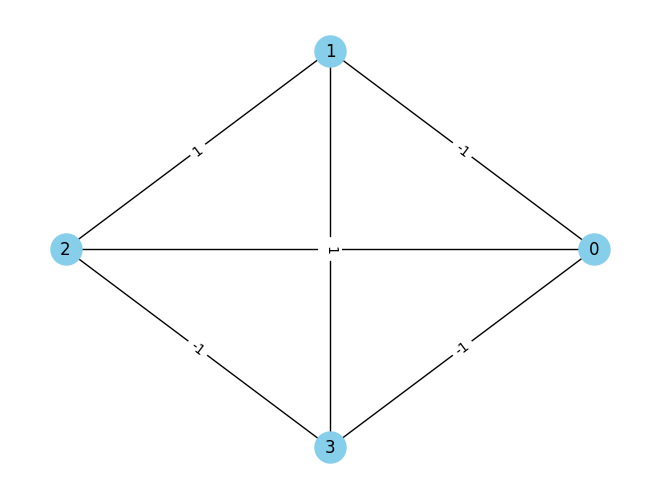

グラフを隣接行列としてCSVファイル './matrix/graph_N4_WL-1_WH1_D1.csv' に保存しました。
グラフをメタデータ付きで非ゼロエッジ情報としてTXTファイル './matrix/sparse_N4_WL-1_WH1_D1.txt' に保存しました。
JをCSVファイル './matrix/J_N4_WL-1_WH1_D1.csv' に保存しました。


In [2]:
import networkx as nx
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import csv
import os

def generate_maxcut_problem(num_nodes, edge_density=0.5, weight_range=(-10, 10)):
    """
    任意のサイズのMAX-CUT問題を生成する関数（重み0を除外）

    Args:
        num_nodes (int): ノード数
        edge_density (float): エッジの密度 (0~1)
        weight_range (tuple): エッジの重みの範囲 (min, max)

    Returns:
        G (networkx.Graph): MAX-CUT問題のグラフ
    """
    # エッジ密度に基づいてランダムグラフを生成
    G = nx.Graph()
    nodes = list(range(num_nodes))
    G.add_nodes_from(nodes)
    
    # エッジをランダムに生成し、重みを設定
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if np.random.rand() < edge_density:
                # 0を除外した重みを生成
                weight = np.random.choice(
                    [x for x in range(weight_range[0], weight_range[1]+1) if x != 0]
                )
                G.add_edge(i, j, weight=weight)
    
    return G

def maxcut_optimal_value(G):
    """
    MAX-CUT問題の最適値を求める関数（総当たり）

    Args:
        G (networkx.Graph): MAX-CUT問題のグラフ

    Returns:
        optimal_value (int): 最適なカット値
        optimal_cut (tuple): 最適なカット（2つのノード集合のペア）
    """
    nodes = list(G.nodes)
    num_nodes = len(nodes)
    max_value = float('-inf')
    best_cut = None

    # すべての可能な分割を試す（総当たり）
    for i in range(1, num_nodes // 2 + 1):
        for subset in combinations(nodes, i):
            set1 = set(subset)
            set2 = set(nodes) - set1
            cut_value = sum(G[u][v]['weight'] for u in set1 for v in set2 if G.has_edge(u, v))
            if cut_value > max_value:
                max_value = cut_value
                best_cut = (set1, set2)

    return max_value, best_cut

def save_graph_as_csv(G, filename):
    """
    グラフを隣接行列形式でCSVに保存する関数

    Args:
        G (networkx.Graph): グラフ
        filename (str): 保存するCSVファイル名
    """
    # 隣接行列をNumPy配列として取得
    adjacency_matrix = nx.to_numpy_array(G, weight='weight', dtype=int)

    # CSVファイルに書き出し
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # 書き出し
        writer.writerows(adjacency_matrix)

def save_negated_graph_as_csv(G, filename):
    """
    グラフのエッジ重みを正負反転させたグラフをCSVに保存する関数

    Args:
        G (networkx.Graph): グラフ
        filename (str): 保存するCSVファイル名
    """
    # グラフのコピーを作成し、エッジ重みを正負反転
    negated_G = G.copy()
    for u, v, data in negated_G.edges(data=True):
        data['weight'] = -data['weight']

    # 隣接行列をNumPy配列として取得
    adjacency_matrix = nx.to_numpy_array(negated_G, weight='weight', dtype=int)

    # CSVファイルに書き出し
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(adjacency_matrix)

def save_nonzero_elements_with_metadata_as_txt(G, num_nodes, optimal_value, filename):
    """
    グラフのエッジ情報を「row column value」形式でTXTに保存し、
    先頭にnum_nodesとoptimal_valueを追加する関数

    Args:
        G (networkx.Graph): グラフ
        num_nodes (int): ノード数
        optimal_value (int): 最適カット値
        filename (str): 保存するTXTファイル名
    """
    with open(filename, mode='w') as file:
        # num_nodes と optimal_value を最初に書き込み
        file.write(f"{num_nodes}\n")
        file.write(f"{optimal_value}\n")
        
        # 非ゼロエッジ情報を「row column value」形式で書き込み
        for u, v, data in G.edges(data=True):
            weight = data['weight']
            if weight != 0:
                file.write(f"{u} {v} {weight}\n")

# ディレクトリが存在しない場合に作成する
os.makedirs('./matrix', exist_ok=True)

# 問題の生成
num_nodes = 5  # ノード数
edge_density = 1  # エッジ密度
weight_range = (-1, 1)  # エッジの重み範囲（整数）
G = generate_maxcut_problem(num_nodes, edge_density, weight_range)

# 最適値を求める
optimal_value, optimal_cut = maxcut_optimal_value(G)

# 結果を表示
print("生成したグラフ:")
for u, v, data in G.edges(data=True):
    print(f"  {u}-{v}: weight = {data['weight']}")

print("\n最適なカット値:", optimal_value)
print("最適なカット:", optimal_cut)

# グラフの描画（Circular Layoutを使用）
pos = nx.circular_layout(G)  # ノードを円形に配置
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=500)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.show()

# グラフをCSVに保存
csv_filename = f'./matrix/graph_N{num_nodes}_WL{weight_range[0]}_WH{weight_range[1]}_D{edge_density}.csv'
save_graph_as_csv(G, csv_filename)

print(f"グラフを隣接行列としてCSVファイル '{csv_filename}' に保存しました。")

# 使用例
txt_filename_with_metadata = f'./matrix/sparse_N{num_nodes}_WL{weight_range[0]}_WH{weight_range[1]}_D{edge_density}.txt'
save_nonzero_elements_with_metadata_as_txt(G, num_nodes, optimal_value, txt_filename_with_metadata)

print(f"グラフをメタデータ付きで非ゼロエッジ情報としてTXTファイル '{txt_filename_with_metadata}' に保存しました。")

# JをCSVに保存
negated_csv_filename = f'./matrix/J_N{num_nodes}_WL{weight_range[0]}_WH{weight_range[1]}_D{edge_density}.csv'
save_negated_graph_as_csv(G, negated_csv_filename)

print(f"JをCSVファイル '{negated_csv_filename}' に保存しました。")


I0_min: 0.06963106238227915, I0_max: 6.963106238227914, Control: 1
Trial 1, Cut value: -2, Optimal Value: 2
Histories saved.


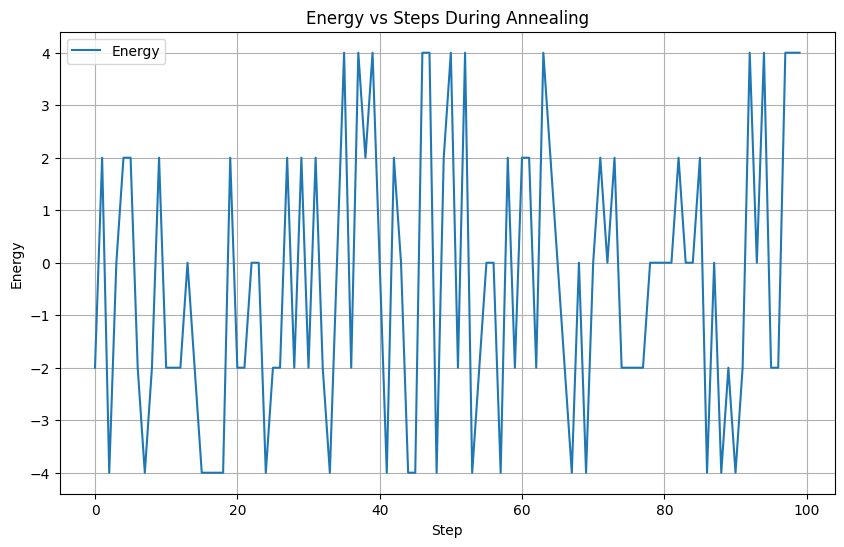

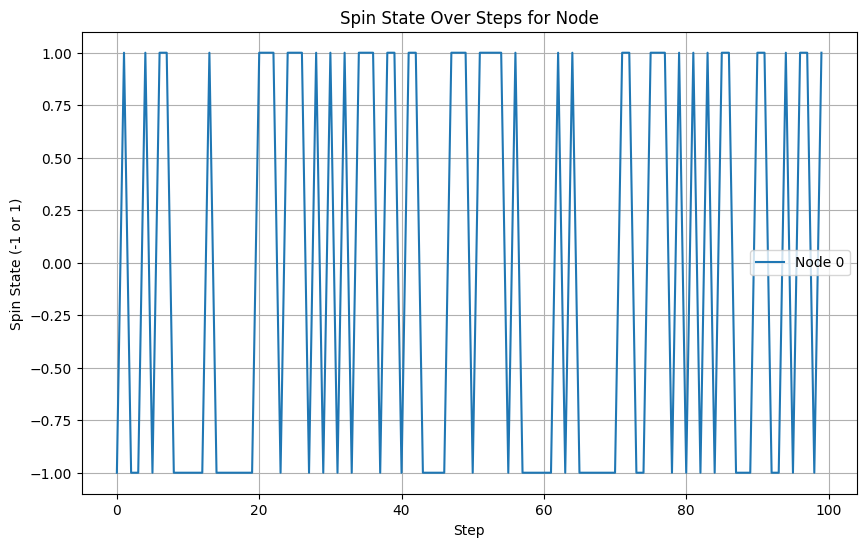

Results saved.


In [3]:
import numpy as np
import time
import random
import math
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd

def annealing(tau, I0_min, I0_max, beta, nrnd, J_matrix, spin_vector, Itanh_ini, rand_type, cycle, control, algorithm):
    Itanh = Itanh_ini
    spin_history = []
    energy_history = []

    I0 = I0_min
    for _ in range(cycle):  # Loop for the number of cycles
        for _ in range(tau):  # Repeat for the number of tau
            if algorithm == 0:  # pSA (probabilistic Simulated Annealing)
                rnd = generate_random(rand_type, len(spin_vector))
                I_vector = np.dot(J_matrix, spin_vector)
                Itanh = np.tanh(I0 * I_vector) + nrnd * rnd
            elif algorithm == 1:  # SSA (Stochastic Simulated Annealing)
                rnd = np.random.randint(0, 2, (len(spin_vector), 1))  # Generate random noise of 0 and 1
                rnd = np.where(rnd == 0, -1, 1)  # Convert noise to -1 and 1
                I_vector = np.dot(J_matrix, spin_vector) + nrnd * rnd
                Itanh = fun_Itanh(Itanh, I_vector, I0)
            spin_vector = np.where(Itanh >= 0, 1, -1)
            spin_history.append(spin_vector.copy())
            energy_history.append(energy_calculate(J_matrix, spin_vector))
        if control == 0:  # Normal control
            I0 /= beta  # Update I0 using beta
    return spin_vector, spin_history, energy_history

# Define the fun_Itanh function, which calculates and returns the Itanh value based on inputs
def fun_Itanh(Itanh, I_vector, I0):
    discriminant = Itanh + I_vector
    Itanh = np.where(discriminant >= I0, I0, discriminant)
    Itanh = np.where(discriminant < -I0, -I0, Itanh)
    return Itanh

def generate_random(rand_type, size):
    if rand_type == 0:
        return 2.0 * np.random.rand(size, 1) - 1.0
    elif rand_type == 1:
        return 1 / 10 * np.random.poisson(10, (size, 1)) - 1.0

def cut_calculate(G_matrix, spin_vector):
    spin_vector_reshaped = spin_vector.ravel()
    upper_triangle = np.triu_indices(len(spin_vector), k=1)
    cut_val = np.sum(
        G_matrix[upper_triangle] * (1 - np.outer(spin_vector_reshaped, spin_vector_reshaped)[upper_triangle])
    )
    return int(cut_val / 2)

def energy_calculate(J_matrix, spin_vector):
    Jm_tmp = np.dot(J_matrix, spin_vector)
    return -np.sum(Jm_tmp * spin_vector) / 2

def get_graph(vertex, lines):
    G_matrix = np.zeros((vertex, vertex), int)
    for line_text in lines:
        i, j, weight = map(int, line_text.split())
        G_matrix[i-1, j-1] = weight
    return G_matrix + G_matrix.T

def read_and_process_file(file_path):
    with open(file_path, 'r') as f:
        vertex = int(f.readline().strip())
        optimal_value = int(f.readline().strip())
        lines = f.readlines()
    G_matrix = get_graph(vertex, lines)
    return vertex, G_matrix, -G_matrix, optimal_value

def save_results(spin_history, energy_history):
    os.makedirs("./history", exist_ok=True)
    energy_history_df = pd.DataFrame({"Energy": energy_history})
    energy_history_df.to_csv("./history/energy_history.csv", index_label="Step")

    spin_history_matrix = np.hstack(spin_history)
    spin_history_df = pd.DataFrame(spin_history_matrix.T)
    spin_history_df.to_csv("./history/spin_history.csv", index_label="Step", header=[f"Node_{i}" for i in range(spin_history_matrix.shape[0])])
    print("Histories saved.")

def plot_results(energy_history, spin_history, node_index=0):
    plt.figure(figsize=(10, 6))
    plt.plot(energy_history, label="Energy")
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.title("Energy vs Steps During Annealing")
    plt.legend()
    plt.grid()
    plt.show()

    node_spin_history = [spin[node_index, 0] for spin in spin_history]
    plt.figure(figsize=(10, 6))
    plt.plot(node_spin_history, label=f"Node {node_index}")
    plt.xlabel("Step")
    plt.ylabel("Spin State (-1 or 1)")
    plt.title("Spin State Over Steps for Node")
    plt.legend()
    plt.grid()
    plt.show()

def save_summary(data, file_path="./result/result.csv"):
    os.makedirs("./result", exist_ok=True)
    header = [
        'algorithm', 'graph', '#node', 'Optimal value', 'gamma', 'delta', 'rand_type', 
        'mean', 'max', 'min', 'mean%', 'max%', 'sim_time'
    ]
    write_header = not os.path.isfile(file_path)
    with open(file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if write_header:
            writer.writerow(header)
        writer.writerow(data)

def main():
    num_nodes = 5  # Number of nodes
    edge_density = 1  # Edge density
    weight_range = (-1, 1)  # Range of edge weights (integers)
    
    cycle, trial, tau = 100, 1, 1
    gamma, delta = 0.1, 10  # Parameters for pSA
    rand_type = 0  # 0: normal distribution, 1: Poisson
    control = 1  # 0: normal, 1: static
    algorithm = 0  # 0: pSA, 1: SSA
    node_index = 0  # Node index for plotting

    graph_file = f'./matrix/sparse_N{num_nodes}_WL{weight_range[0]}_WH{weight_range[1]}_D{edge_density}.txt'

    # Create directories if they do not exist
    os.makedirs('./history', exist_ok=True)
    os.makedirs('./result', exist_ok=True)

    vertex, G_matrix, J_matrix, optimal_value = read_and_process_file(graph_file)
 
    if algorithm == 0:
        sigma = np.mean([np.sqrt((vertex - 1) * np.var(J_matrix[j])) for j in range(vertex)])
        I0_min, I0_max = gamma / sigma, delta / sigma
        nrnd   = np.float32(1)
    elif algorithm == 1:
        mean_each = []
        std_each = []
        for j in range(vertex):
            mean_each.append((vertex-1)*np.mean(J_matrix[j]))
            std_each.append(np.sqrt((vertex-1)*np.var(np.concatenate([J_matrix[j],-J_matrix[j]]))))
        sigma = np.mean(std_each)
        mean = np.mean(mean_each)
        I0_min = np.float32(np.max(std_each) * 0.01 + np.min(np.abs(mean_each)))
        I0_max = np.float32(np.max(std_each) * 2 + np.min(np.abs(mean_each)))
        nrnd = np.float32(0.67448975*sigma*np.ones((vertex,1)))
    beta = (I0_min / I0_max) ** (tau / (cycle - 1))
    print(f'I0_min: {I0_min}, I0_max: {I0_max}, Control: {control}')
    Itanh_ini = (np.random.randint(0, 3, (vertex, 1)) - 1) * I0_min

    cut_sum, time_sum, cut_list = 0, 0, []
    for k in range(trial):
        ini_spin_vector = np.random.choice([-1, 1], size=(vertex, 1))
        last_spin_vector, spin_history, energy_history = annealing(
            tau, I0_min, I0_max, beta, 1, J_matrix, ini_spin_vector, Itanh_ini, rand_type, cycle, control, algorithm,
        )
        cut_val = cut_calculate(G_matrix, last_spin_vector)
        cut_sum += cut_val
        cut_list.append(cut_val)
        print(f"Trial {k + 1}, Cut value: {cut_val}, Optimal Value: {optimal_value}")

    save_results(spin_history, energy_history)
    plot_results(energy_history, spin_history, node_index)

    cut_avg = cut_sum / trial
    data = [algorithm, graph_file, vertex, optimal_value, gamma, delta, rand_type, cut_avg, max(cut_list), min(cut_list)]
    save_summary(data)
    print("Results saved.")

if __name__ == "__main__":
    main()
